# Imports

In [80]:
from helpers import preprocessing, extract_links, path_to_name, replace_return
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup # To Extract all the URLs from the HTML page

# Downloading the data

In [2]:
dfs = preprocessing()

# Extraction of the links position
## List of paths to access the articles htm


In [3]:
list_articles_paths = []

# Iterate through all the htm files in all subfolders from the main folder wp 
for root, dirs, subfolders in os.walk('dataset/wpcd/wp/'):
    for file in subfolders:
        # Select only the htm files
        if file.endswith('.htm'):
            file_path = os.path.join(root, file)
            # Store htm usefull for the game 
            if '/index/' not in file_path:
                list_articles_paths.append(file_path)

len(list_articles_paths)

5237

In [4]:
def classify_href(links, length_page, source_name):
    """ It classifies each link from a provided list 
    parameters:
        links: list of bs4.element.Tag
        length_page: int, length of the article htm from which the links are from
        source_name: str, name of the article from which the links are from 
    return:
        dataFrame containing the name article with their link category and the number of occcurence in the list. 
     """
    categories = pd.DataFrame(columns=['source', 'target', 'category', 'line_position', 'relative_position'])

    # Specification of the categories
    block_level_elements = {'div',      # legend
                             'p',       # text
                            'table'}    # summary tables

    # Go through each link on the page
    for i, link in enumerate(links): 
        element = link

        # Get the line position
        line_position = link.sourceline 

        # Iterate until it find an element from the specified list (block_level_elements)
        while element and element.name not in block_level_elements:
            element = element.find_parent()

        # Rename the categories
        el_name = element.name
        if el_name == 'div':
            el_name = 'legend'
        elif el_name == 'p':
            el_name = 'text'

        # Store a new row with the corresponding info 
        categories.loc[i] = (source_name, path_to_name(link.get('href')), el_name, line_position, np.round(line_position/length_page,3))

    # Groupe the links with multiple occurrences, adjust their category if they belong to more than one, and sum their occurrences.
    categories = categories.groupby(['source', 'target'])[['category', 'line_position', 'relative_position']].agg(list).reset_index()
    categories['count'] = [len(l) for l in categories['category']] 
    categories['group'] = ['|'.join(sorted(np.unique(l))) for l in categories['category']] 
    categories = categories.sort_values(by = 'target')

    return categories


In [20]:
category_repartition = []
articles_df = pd.DataFrame(columns=['source', 'target', 'category', 'line_position', 'relative_position'])

#Iterate in each paths from the list of articles
for path in list_articles_paths:
    with open(path, 'r', encoding='utf-8', errors='replace') as file:
        soup = BeautifulSoup(file, 'html.parser')


    # Selection of the links
    all_links = soup.find_all('a', href=True)
    all_links = [link for link in all_links if '/images/' not in link.get('href') and 
                                                    'disclaimer.htm' not in link.get('href') and 
                                                    '/index/' not in link.get('href')and 
                                                    '.htm' in link.get('href')]
                                                    
    # Classification of the links
    class_ = classify_href(all_links, len(soup.find_all()), path_to_name(path))
    articles_df = pd.concat([articles_df, class_], axis = 0)

    category_repartition.append(class_.groupby(['group']).sum('count').rename(columns={'count': path_to_name(path)}))


# Calculation of the number of element in each categorise and their corresponding percentage 
category_repartition_df = pd.concat(category_repartition.copy(), axis = 1)
category_repartition_df.fillna(0, inplace = True)

repartition_summary = pd.DataFrame(columns = ['sum', 'percentage'])
repartition_summary['sum'] = category_repartition_df.sum(axis = 1).astype(int)
repartition_summary['percentage'] = np.round(repartition_summary['sum'].div(repartition_summary['sum'].sum()) * 100, 2)
    

In [21]:
articles_df

,source,target,category,line_position,relative_position,count,group
0,Royal_Marines,15th_Marine_Expeditionary_Unit,[text],[308],[0.521],1.0,text
1,Royal_Marines,Afghanistan,"[text, text, text]","[308, 308, 308]","[0.521, 0.521, 0.521]",3.0,text
2,Royal_Marines,American_Revolutionary_War,[text],[293],[0.496],1.0,text
3,Royal_Marines,Antwerp,"[text, text]","[296, 302]","[0.501, 0.511]",2.0,text
4,Royal_Marines,Argentina,[text],[308],[0.521],1.0,text
...,...,...,...,...,...,...,...
116,World_War_II,Warsaw,[text],[150],[0.108],1.0,text
117,World_War_II,Wikipedia_Text_of_the_GNU_Free_Documentation_L...,[legend],[650],[0.469],1.0,legend
118,World_War_II,Winston_Churchill,"[table, text, text, text, text]","[90, 242, 270, 409, 505]","[0.065, 0.175, 0.195, 0.295, 0.364]",5.0,table|text
119,World_War_II,Yugoslavia,[text],[224],[0.162],1.0,text


In [22]:
repartition_summary

,sum,percentage
group,,
legend,21143,11.00
table,14033,7.30
table|text,19061,9.92
text,128974,67.09
legend|text,6485,3.37
legend|table|text,2312,1.20
legend|table,227,0.12


In [23]:
category_repartition_df

,Royal_Marines,Recycling,Retreat_of_glaciers_since_1850,Remember_Girls_Like_Rajpura,Rutherfordium,Rule_of_St_Benedict,Red_dwarf,Romeo_and_Juliet,Rudyard_Kipling,Race,...,Witold_Pilecki,What_Next_For_Tsunami_Orphans,Walt_Disney,Winter2005_Brick,Winter2005_Stop_Press,Wikispecies,William_Butler_Yeats,Western_painting,William_Ewart_Gladstone,World_War_II
group,,,,,,,,,,,,,,,,,,,,,
legend,2.0,2.0,4.0,16.0,2.0,2.0,2.0,2.0,3.0,2.0,...,3.0,14.0,2.0,14.0,14.0,2.0,2.0,2.0,2.0,7.0
table,1.0,6.0,0.0,2.0,6.0,0.0,0.0,0.0,4.0,0.0,...,1.0,2.0,0.0,2.0,2.0,1.0,0.0,0.0,2.0,1.0
table|text,16.0,5.0,0.0,0.0,6.0,0.0,0.0,0.0,4.0,0.0,...,4.0,0.0,15.0,0.0,0.0,2.0,0.0,0.0,31.0,25.0
text,53.0,17.0,52.0,4.0,11.0,9.0,12.0,12.0,41.0,44.0,...,14.0,2.0,23.0,5.0,5.0,1.0,20.0,114.0,35.0,128.0
legend|text,0.0,3.0,8.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,6.0
legend|table|text,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,19.0
legend|table,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
print('Categories repartition')
display(repartition_summary)
print('\nPercentage of link being in multiple categories: {}%'.format(repartition_summary.loc[repartition_summary.index.str.contains('\|'),'percentage'].sum()))

Categories repartition


,sum,percentage
group,,
legend,21143,11.00
table,14033,7.30
table|text,19061,9.92
text,128974,67.09
legend|text,6485,3.37
legend|table|text,2312,1.20
legend|table,227,0.12



Percentage of link being in multiple categories: 14.609999999999998%


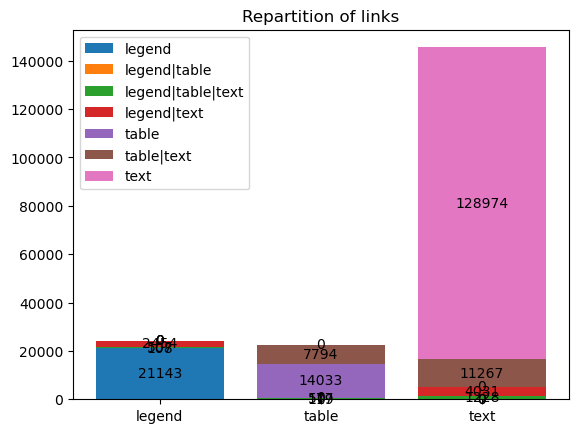

In [82]:
grouped_dict = {}

# Create storage adequat for the plot
plot_article = articles_df.copy()[['group', 'category']].explode('category')
plot_article = plot_article.groupby(['group', 'category']).size().reset_index(name='Count')
categories_order = plot_article.category.unique()

empty_cat = pd.DataFrame(index = plot_article.category.unique())

for category in plot_article.group.unique():
    category_group = plot_article[plot_article['group'] == category]
    category_group.index = category_group.category
    category_group = category_group.drop(['group', 'category'], axis = 1)
   
    cat_group = pd.concat([category_group, empty_cat], axis = 1).fillna(0)
    cat_group =cat_group.reindex(categories_order)
    counts_array = cat_group['Count'].to_numpy()
    grouped_dict[category] = counts_array

# Plot
fig, ax = plt.subplots()

# Plot parameters
width = 0.8  # the width of the bars
bottom = np.zeros(3) #where to put the color on scale for each category 

# Add each bar by group color 
for group, category_count in grouped_dict.items():
    p = ax.bar(categories_order, category_count, width, label=group, bottom=bottom)
    bottom += category_count

    ax.bar_label(p, label_type='center')

ax.set_title('Repartition of links')
ax.legend()

plt.show()

del empty_cat, plot_article, grouped_dict, cat_group, counts_array, categories_order

# Linkage with the frequence of visit

In [83]:
paths =  pd.concat([dfs['paths_unfinished'].path, dfs['paths_finished'].path], axis=0)
paths = paths.str.split(';')
paths = paths[paths.apply(lambda x: len(x) != 1)].reset_index(drop=True)
paths_df = pd.concat([paths, paths], axis = 1)
paths_df.columns = ['original', 'modified']
paths_df.modified = [replace_return(list_) for list_ in paths_df.modified]
paths_df

,original,modified
0,"[Malawi, Democracy, Alexander_the_Great]","[Malawi, Democracy, Alexander_the_Great]"
1,"[Paraguay, Bolivia]","[Paraguay, Bolivia]"
2,"[Agriculture, History_of_the_world, China, Yan...","[Agriculture, History_of_the_world, China, Yan..."
3,"[Mind, Christianity, Europe, Renaissance, Anci...","[Mind, Christianity, Europe, Renaissance, Anci..."
4,"[4-2-0, United_States, Agriculture, Sugar, Aus...","[4-2-0, United_States, Agriculture, Sugar, Aus..."
...,...,...
70963,"[Yagan, Ancient_Egypt, Civilization]","[Yagan, Ancient_Egypt, Civilization]"
70964,"[Yagan, Folklore, Brothers_Grimm, <, 19th_cent...","[Yagan, Folklore, Brothers_Grimm, .Folklore, 1..."
70965,"[Yagan, Australia, England, France, United_Sta...","[Yagan, Australia, England, France, United_Sta..."
70966,"[Yarralumla,_Australian_Capital_Territory, Aus...","[Yarralumla,_Australian_Capital_Territory, Aus..."


In [84]:
# Verify the function replace_return works for divers cases 

a = paths.copy()

# Cases to test j = {70964, 14, 17, 100}
j = 17
display(a.iloc[j])
replace_return(a.iloc[j])


['Second_Congo_War',
 'World_War_II',
 'United_Kingdom',
 'Scotland',
 'Glasgow',
 '<',
 'Outer_Hebrides',
 '<']

['Second_Congo_War',
 'World_War_II',
 'United_Kingdom',
 'Scotland',
 'Glasgow',
 '.Scotland',
 'Outer_Hebrides',
 '.Scotland']

In [95]:
# Separating the original lists as new list of list of 2 articles (source, target)
link_table_user = [list_[i:i+2] for list_ in paths_df.modified for i in range(len(list_)-1)]
link_table_user = pd.DataFrame(link_table_user, columns=['source', 'target'])
link_table_user.sort_values(by = 'source', inplace = True)

# Remove the row with target starting with a point --> remove the return which are not a user link selection
link_table_user = link_table_user[~link_table_user['target'].str.startswith('.')]

# We don't need to know the past of the source article --> remove the return indication
link_table_user['source'] = link_table_user['source'].str.lstrip('.')

# Count how many times the link between the source and the direct target articles are selected
link_table_user = link_table_user.groupby(['source', 'target']).size().reset_index(name='count_link_selection')

display(link_table_user)

,source,target,count_link_selection
0,10th_century,11th_century,21
1,10th_century,9th_century,33
2,10th_century,Algeria,2
3,10th_century,Beer,2
4,10th_century,Byzantine_Empire,5
...,...,...,...
58955,Édouard_Manet,Renaissance,1
58956,Éire,Canada,1
58957,Éire,Ireland,3
58958,Éire,Republic_of_Ireland,1


In [99]:
print('The more used path was selected {} times.'.format(max(link_table_user.count_link_selection)))
link_table_user[link_table_user.count_link_selection >= 500]

The more used path was selected 709 times.


,source,target,count_link_selection
3822,Animal,Mammal,705
8944,Brain,Computer_science,709
13603,Communication,Telephone,539
19254,Europe,United_Kingdom,634
38530,North_America,United_States,677
54803,United_Kingdom,England,511
55220,United_States,President_of_the_United_States,553


In [100]:
# Add the link selection to the article_df dataframe
articles_df = articles_df.merge(link_table_user, on = ['source', 'target'], how= 'outer')
articles_df.fillna(0, inplace = True)
display(articles_df)

,source,target,category,line_position,relative_position,count,group,count_link_selection
0,Royal_Marines,15th_Marine_Expeditionary_Unit,[text],[308],[0.521],1.0,text,1.0
1,Royal_Marines,Afghanistan,"[text, text, text]","[308, 308, 308]","[0.521, 0.521, 0.521]",3.0,text,0.0
2,Royal_Marines,American_Revolutionary_War,[text],[293],[0.496],1.0,text,0.0
3,Royal_Marines,Antwerp,"[text, text]","[296, 302]","[0.501, 0.511]",2.0,text,0.0
4,Royal_Marines,Argentina,[text],[308],[0.521],1.0,text,3.0
...,...,...,...,...,...,...,...,...
141925,World_War_II,Warsaw,[text],[150],[0.108],1.0,text,5.0
141926,World_War_II,Wikipedia_Text_of_the_GNU_Free_Documentation_L...,[legend],[650],[0.469],1.0,legend,0.0
141927,World_War_II,Winston_Churchill,"[table, text, text, text, text]","[90, 242, 270, 409, 505]","[0.065, 0.175, 0.195, 0.295, 0.364]",5.0,table|text,41.0
141928,World_War_II,Yugoslavia,[text],[224],[0.162],1.0,text,10.0


# Tried first attempt on statistical test, but need to verified they are correct due to the highly unbalanced nature of the data 

In [102]:
# For the source-target link that appear more than once, compute their position mean (for the statistical test)
articles_df['relative_position_mean'] = [np.mean(pos) for pos in articles_df.relative_position]
articles_df

,source,target,category,line_position,relative_position,count,group,count_link_selection,relative_position_mean
0,Royal_Marines,15th_Marine_Expeditionary_Unit,[text],[308],[0.521],1.0,text,1.0,0.5210
1,Royal_Marines,Afghanistan,"[text, text, text]","[308, 308, 308]","[0.521, 0.521, 0.521]",3.0,text,0.0,0.5210
2,Royal_Marines,American_Revolutionary_War,[text],[293],[0.496],1.0,text,0.0,0.4960
3,Royal_Marines,Antwerp,"[text, text]","[296, 302]","[0.501, 0.511]",2.0,text,0.0,0.5060
4,Royal_Marines,Argentina,[text],[308],[0.521],1.0,text,3.0,0.5210
...,...,...,...,...,...,...,...,...,...
141925,World_War_II,Warsaw,[text],[150],[0.108],1.0,text,5.0,0.1080
141926,World_War_II,Wikipedia_Text_of_the_GNU_Free_Documentation_L...,[legend],[650],[0.469],1.0,legend,0.0,0.4690
141927,World_War_II,Winston_Churchill,"[table, text, text, text, text]","[90, 242, 270, 409, 505]","[0.065, 0.175, 0.195, 0.295, 0.364]",5.0,table|text,41.0,0.2188
141928,World_War_II,Yugoslavia,[text],[224],[0.162],1.0,text,10.0,0.1620


In [106]:
unique_group = articles_df.copy()[articles_df.group.isin(['text', 'table', 'legend'])]
len(unique_group)/len(articles_df)

0.9390192348340731

In [104]:
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

<Axes: xlabel='group', ylabel='relative_position_mean'>

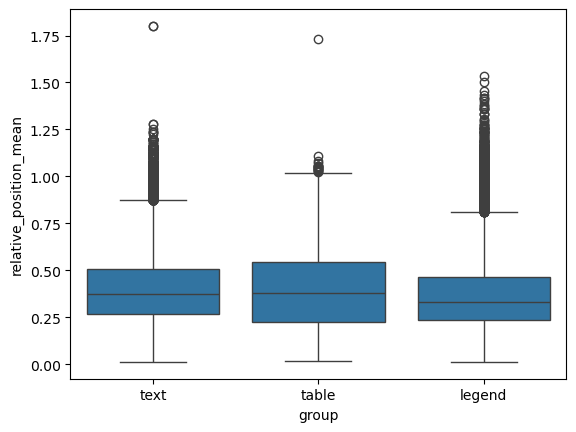

In [107]:
# Boxplot of count_link ditribution according to the unique category 
#sns.boxplot(x='group', y='count_link_selection', data=unique_group)
#sns.boxplot(x='group', y='count_link_selection', data=unique_group[unique_group.count_link_selection >0])
#sns.boxplot(x='group', y='count_link_selection', data=unique_group[unique_group.count_link_selection >10])
#sns.boxplot(x='group', y='count_link_selection', data=unique_group[unique_group.count_link_selection >100])

# Boxplot of relative_position_mean ditribution according to the unique category 
sns.boxplot(x='group', y='relative_position_mean', data=unique_group)


In [110]:
# ANOVA to test for differences between categories
model = ols('relative_position_mean ~ count_link_selection', data=unique_group).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
display(anova_table)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,sum_sq,df,F,PR(>F)
count_link_selection,11.912389,1.0,325.562744,1.086385e-72
Residual,4876.478897,133273.0,NaN,NaN


In [113]:
# Multiple regression
reg = unique_group.copy()[['count_link_selection', 'group', 'count', 'relative_position_mean' ]]
dummies = pd.get_dummies(reg['group']).astype(int)
reg = pd.concat([reg, dummies], axis=1)
reg.drop('group', axis = 1, inplace = True)

model = ols('count_link_selection ~  count + relative_position_mean', data=reg).fit()
print(model.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                             OLS Regression Results                             
Dep. Variable:     count_link_selection   R-squared:                       0.012
Model:                              OLS   Adj. R-squared:                  0.012
Method:                   Least Squares   F-statistic:                     807.2
Date:                  Sun, 03 Dec 2023   Prob (F-statistic):               0.00
Time:                          16:04:57   Log-Likelihood:            -4.9504e+05
No. Observations:                133275   AIC:                         9.901e+05
Df Residuals:                    133272   BIC:                         9.901e+05
Df Model:                             2                                         
Covariance Type:     

In [249]:
model = ols('count_link_selection ~  count + relative_position_mean', data=articles_df).fit()
print(model.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                             OLS Regression Results                             
Dep. Variable:     count_link_selection   R-squared:                       0.021
Model:                              OLS   Adj. R-squared:                  0.021
Method:                   Least Squares   F-statistic:                     1617.
Date:                  Sun, 03 Dec 2023   Prob (F-statistic):               0.00
Time:                          11:32:15   Log-Likelihood:            -5.7977e+05
No. Observations:                153060   AIC:                         1.160e+06
Df Residuals:                    153057   BIC:                         1.160e+06
Df Model:                             2                                         
Covariance Type:     

In [115]:
# Tried non-parametric methods
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn



# Kruskal-Wallis test
result_kruskal = kruskal(unique_group.loc[unique_group.group == 'text', 'count_link_selection'], 
                             unique_group.loc[unique_group.group == 'table', 'count_link_selection'],
                             unique_group.loc[unique_group.group == 'legend', 'count_link_selection'])



# Results interpretation with significance level 
if result_kruskal.pvalue < 0.05:
    print("Kruskal-Wallis Test:")
    print("H-statistic:", result_kruskal.statistic)
    print("P-value:", result_kruskal.pvalue)
    print("There is a statistically significant difference between at least two groups.\n")

    # Dunn's test for post-hoc analysis
    dunn_result = posthoc_dunn(unique_group, val_col='count_link_selection', group_col='group', p_adjust='bonferroni')

    print("Dunn's Test:")
    print(dunn_result)
else:
    print("No significant difference detected in the Kruskal-Wallis test.")


Kruskal-Wallis Test:
H-statistic: 13382.189889613519
P-value: 0.0
There is a statistically significant difference between at least two groups.

Dunn's Test:
        legend  table  text
legend     1.0    0.0   0.0
table      0.0    1.0   0.0
text       0.0    0.0   1.0


In [116]:
# Maybe do something with cross-validation on text samples to have balanced one